In [ ]:
# ============================================================
# RANDOM SEARCH DE HIPERPARÂMETROS INICIAL - LSTM (FD001 - C-MAPSS)
# ============================================================

import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers

# ============================================================
# Configurações iniciais
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

# ============================================================
# Leitura dos dados FD001
# ============================================================
base = "/CMAPSSData/"
train = pd.read_csv(base + "train_FD001.txt", sep=r"\s+", header=None)
test  = pd.read_csv(base + "test_FD001.txt",  sep=r"\s+", header=None)
rul   = pd.read_csv(base + "RUL_FD001.txt",   sep=r"\s+", header=None)
print(f"Train: {train.shape}, Test: {test.shape}, RULs: {rul.shape}")

# ============================================================
# Preparação dos dados e RUL
# ============================================================
col_names = ["unit_nr", "time_cycles", "setting_1", "setting_2", "setting_3"] + [f"s{i}" for i in range(1, 22)]
train.columns, test.columns = col_names, col_names

rul_cap = 125
rul_dict = {i+1: rul.iloc[i, 0] for i in range(len(rul))}

def add_rul(df, is_test=False):
    df = df.copy()
    max_cycles = df.groupby("unit_nr")["time_cycles"].max().reset_index()
    max_cycles.columns = ["unit_nr", "max_cycle"]
    df = df.merge(max_cycles, on="unit_nr", how="left")
    df["RUL"] = df["max_cycle"] - df["time_cycles"]
    if is_test:
        df["RUL"] += df["unit_nr"].map(rul_dict)
    df.drop("max_cycle", axis=1, inplace=True)
    df["RUL"] = df["RUL"].clip(upper=rul_cap)
    return df

train = add_rul(train)
test = add_rul(test, is_test=True)

# ============================================================
# Remoção de sensores constantes
# ============================================================
const_cols = [c for c in train.columns if train[c].nunique() == 1]
train.drop(columns=const_cols, inplace=True)
test.drop(columns=const_cols, inplace=True)
print(f"Removidos sensores constantes: {const_cols}")

# ============================================================
# Normalização por unidade
# ============================================================
feature_cols = [c for c in train.columns if c not in ["unit_nr", "time_cycles", "RUL"]]
scaler = MinMaxScaler()

def scale_by_unit(df):
    scaled = []
    for u in df["unit_nr"].unique():
        unit_df = df[df["unit_nr"] == u].copy()
        unit_df[feature_cols] = scaler.fit_transform(unit_df[feature_cols])
        scaled.append(unit_df)
    return pd.concat(scaled, axis=0).reset_index(drop=True)

train_scaled = scale_by_unit(train)
test_scaled = scale_by_unit(test)
print("Normalização concluída.")

# ============================================================
# Função para criar janelas
# ============================================================
def make_sequences(df, window_size=30):
    X, y, units = [], [], []
    for u in df["unit_nr"].unique():
        unit_df = df[df["unit_nr"] == u]
        features = unit_df[feature_cols].values
        rul_vals = unit_df["RUL"].values
        for i in range(len(features) - window_size):
            X.append(features[i:i+window_size])
            y.append(rul_vals[i+window_size])
            units.append(u)
    return np.array(X), np.array(y), np.array(units)

WINDOW_SIZE = 30
X_all, y_all, units_all = make_sequences(train_scaled, WINDOW_SIZE)
print(f"Janelas treino/validação: {X_all.shape}")

# ============================================================
# Divisão temporal 80/20 por unidade
# ============================================================
unique_units = np.unique(units_all)
n_train = int(len(unique_units) * 0.8)
train_units = unique_units[:n_train]
val_units = unique_units[n_train:]

mask_train = np.isin(units_all, train_units)
mask_val   = np.isin(units_all, val_units)

X_train, y_train = X_all[mask_train], y_all[mask_train]
X_val,   y_val   = X_all[mask_val],   y_all[mask_val]

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")

# ============================================================
# Função construtora do modelo
# ============================================================
def build_model(n_timesteps, n_features, lstm1=64, lstm2=32, dropout=0.2, lr=1e-3):
    model = keras.Sequential([
        layers.Input(shape=(n_timesteps, n_features)),
        layers.LSTM(lstm1, return_sequences=True),
        layers.Dropout(dropout),
        layers.LSTM(lstm2),
        layers.Dropout(dropout),
        layers.Dense(1, activation="linear")
    ])
    model.compile(
        loss="mse",
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        metrics=[keras.metrics.MeanAbsoluteError(name="mae"),
                 keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    return model

# ============================================================
# Random Search de hiperparâmetros
# ============================================================
param_grid = {
    "lstm1": [32, 64, 128],
    "lstm2": [16, 32, 64],
    "dropout": [0.1, 0.2, 0.3],
    "lr": [1e-2, 1e-3, 5e-4, 1e-4],
    "batch_size": [64, 128, 256]
}

N_TRIALS = 20
results = []
n_timesteps, n_features = X_train.shape[1], X_train.shape[2]

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr  = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=0)

for i in range(N_TRIALS):
    params = {k: random.choice(v) for k, v in param_grid.items()}
    print(f"\n Rodando combinação {i+1}/{N_TRIALS}: {params}")

    model = build_model(n_timesteps, n_features,
                        lstm1=params["lstm1"],
                        lstm2=params["lstm2"],
                        dropout=params["dropout"],
                        lr=params["lr"])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=80,
        batch_size=params["batch_size"],
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    y_pred = model.predict(X_val, verbose=0).flatten()
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    results.append({**params, "mae": mae, "rmse": rmse})
    print(f"MAE={mae:.2f} | RMSE={rmse:.2f}")

# ============================================================
# Resultados consolidados
# ============================================================
results_df = pd.DataFrame(results).sort_values(by="rmse").reset_index(drop=True)
print("\n===== RESULTADOS (ordenados por RMSE) =====")
display(results_df)

# ============================================================
# Melhor configuração
# ============================================================
best_params = results_df.iloc[0].to_dict()
print("\n Melhor configuração encontrada:")
for k, v in best_params.items():
    print(f"{k}: {v}")


In [ ]:
# ============================================================
# MODELO LSTM INICIAL - (FD001 - C-MAPSS)
# Modelo inicial: normalização por unidade
# ============================================================

import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers

# ============================================================
# CONFIGURAÇÕES INICIAIS
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

# ============================================================
# LEITURA DOS DADOS FD001
# ============================================================
base = "CMAPSSData/"
train = pd.read_csv(base + "train_FD001.txt", sep=r"\s+", header=None)
test  = pd.read_csv(base + "test_FD001.txt",  sep=r"\s+", header=None)
rul   = pd.read_csv(base + "RUL_FD001.txt",   sep=r"\s+", header=None)

col_names = ["unit_nr", "time_cycles", "setting_1", "setting_2", "setting_3"] \
            + [f"s{i}" for i in range(1, 22)]
train.columns = col_names
test.columns  = col_names

print("Train:", train.shape, "Test:", test.shape)

# ============================================================
# CÁLCULO DO RUL
# ============================================================
rul_cap = 125
rul_dict = {i+1: rul.iloc[i, 0] for i in range(len(rul))}

def add_rul(df, is_test=False):
    df = df.copy()
    max_cycles = df.groupby("unit_nr")["time_cycles"].max().reset_index()
    max_cycles.columns = ["unit_nr", "max_cycle"]
    df = df.merge(max_cycles, on="unit_nr", how="left")
    df["RUL"] = df["max_cycle"] - df["time_cycles"]

    if is_test:
        df["RUL"] += df["unit_nr"].map(rul_dict)

    df.drop("max_cycle", axis=1, inplace=True)
    df["RUL"] = df["RUL"].clip(upper=rul_cap)
    return df

train = add_rul(train)
test  = add_rul(test, is_test=True)

# ============================================================
# REMOÇÃO DOS SENSORES CONSTANTES
# ============================================================
const_cols = [c for c in train.columns if train[c].nunique() == 1]
train.drop(columns=const_cols, inplace=True)
test.drop(columns=const_cols, inplace=True)

print("Sensores removidos:", const_cols)

# ============================================================
# NORMALIZAÇÃO CONSISTENTE ENTRE TREINO E TESTE
# ============================================================

feature_cols = [c for c in train.columns if c not in ["unit_nr", "time_cycles", "RUL"]]

# ARMAZENAR UM SCALER POR MOTOR DO TREINO
train_scalers = {}

def scale_train(df):
    scaled = []
    for u in df["unit_nr"].unique():
        unit_df = df[df["unit_nr"] == u].copy()
        scaler = MinMaxScaler()
        unit_df[feature_cols] = scaler.fit_transform(unit_df[feature_cols])
        train_scalers[u] = scaler
        scaled.append(unit_df)
    return pd.concat(scaled).reset_index(drop=True)

def scale_test(df):
    scaled = []
    for u in df["unit_nr"].unique():
        unit_df = df[df["unit_nr"] == u].copy()

        if u not in train_scalers:
            raise ValueError(f"Motor {u} não existe no treino!")

        scaler = train_scalers[u]
        unit_df[feature_cols] = scaler.transform(unit_df[feature_cols])

        scaled.append(unit_df)
    return pd.concat(scaled).reset_index(drop=True)

train_scaled = scale_train(train)
test_scaled  = scale_test(test)

print("Normalização consistente concluída.")

# ============================================================
# CRIAÇÃO DE JANELAS (TRAIN / VAL)
# ============================================================
def make_sequences(df, window_size=30):
    X, y, units = [], [], []
    for u in df["unit_nr"].unique():
        unit_df = df[df["unit_nr"] == u]
        feat = unit_df[feature_cols].values
        rul  = unit_df["RUL"].values

        for i in range(len(feat) - window_size):
            X.append(feat[i:i+window_size])
            y.append(rul[i+window_size])
            units.append(u)

    return np.array(X), np.array(y), np.array(units)

WINDOW = 30
X_all, y_all, units_all = make_sequences(train_scaled, WINDOW)

# ============================================================
# DIVISÃO TEMPORAL 80/20 POR UNIDADE
# ============================================================
unique_units = np.unique(units_all)
n_train = int(0.8 * len(unique_units))
train_units = unique_units[:n_train]
val_units   = unique_units[n_train:]

mask_train = np.isin(units_all, train_units)
mask_val   = np.isin(units_all, val_units)

X_train, y_train = X_all[mask_train], y_all[mask_train]
X_val,   y_val   = X_all[mask_val],   y_all[mask_val]

print("X_train:", X_train.shape, "X_val:", X_val.shape)

# ============================================================
# MODELO LSTM INICIAL
# ============================================================
def build_model():
    model = keras.Sequential([
        layers.Input(shape=(WINDOW, len(feature_cols))),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.1),
        layers.LSTM(64),
        layers.Dropout(0.1),
        layers.Dense(1, activation="linear")
    ])

    model.compile(
        loss="mse",
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        metrics=[
            keras.metrics.MeanAbsoluteError(name="mae"),
            keras.metrics.RootMeanSquaredError(name="rmse")
        ]
    )
    return model

model = build_model()

# ============================================================
# TREINO FINAL
# ============================================================
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr  = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ============================================================
# TESTE FINAL — ÚLTIMA JANELA POR MOTOR
# ============================================================
def make_sequences_test(df, window_size=30):
    X, y = [], []
    for u in df["unit_nr"].unique():
        unit_df = df[df["unit_nr"] == u]
        feat = unit_df[feature_cols].values
        rul  = unit_df["RUL"].values

        X.append(feat[-window_size:])
        y.append(rul[-1])

    return np.array(X), np.array(y)

X_test, y_test = make_sequences_test(test_scaled)

y_pred = model.predict(X_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n=========== RESULTADO FINAL (FD001 - ÚLTIMA JANELA) ===========")
print(f"MAE  = {mae:.2f} ciclos")
print(f"RMSE = {rmse:.2f} ciclos")

# ============================================================
# DISPERSÃO
# ============================================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0,125], [0,125], "r--", label="Ideal")
plt.xlabel("RUL Real")
plt.ylabel("RUL Previsto")
plt.title("FD001 - Última Janela por Motor")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.show()

In [ ]:
# ============================================================
# Primeira Deep LSTM + Residual Connections + Feature Engineering
# ============================================================

import os, random
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# ============================================================
# CONFIGURAÇÕES INICIAIS
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

# ============================================================
# LEITURA DOS DADOS FD001
# ============================================================
base = "CMAPSSData/"
train = pd.read_csv(base + "train_FD001.txt", sep=r"\s+", header=None)
test  = pd.read_csv(base + "test_FD001.txt",  sep=r"\s+", header=None)
rul   = pd.read_csv(base + "RUL_FD001.txt",   sep=r"\s+", header=None)

col_names = ["unit_nr", "time_cycles", "setting_1", "setting_2", "setting_3"] \
    + [f"s{i}" for i in range(1, 22)]
train.columns = col_names
test.columns  = col_names

print("Train:", train.shape, "Test:", test.shape)

# ============================================================
# RUL COM LIMITE (125)
# ============================================================
rul_cap = 125
rul_dict = {i+1: rul.iloc[i, 0] for i in range(len(rul))}

def add_rul(df, is_test=False):
    df = df.copy()
    m = df.groupby("unit_nr")["time_cycles"].max().reset_index()
    m.columns = ["unit_nr", "max_cycle"]
    df = df.merge(m, on="unit_nr", how="left")
    df["RUL"] = df["max_cycle"] - df["time_cycles"]
    if is_test:
        df["RUL"] += df["unit_nr"].map(rul_dict)
    df["RUL"] = df["RUL"].clip(upper=rul_cap)
    df.drop("max_cycle", axis=1, inplace=True)
    return df

train = add_rul(train)
test  = add_rul(test, is_test=True)

# ============================================================
# REMOVE SENSORES CONSTANTES
# ============================================================
const_cols = [c for c in train.columns if train[c].nunique() == 1]
train.drop(columns=const_cols, inplace=True)
test.drop(columns=const_cols, inplace=True)
print("Sensores removidos:", const_cols)

# ============================================================
# FEATURE ENGINEERING
# ============================================================
def add_features(df):
    df = df.copy()
    sensor_cols = [c for c in df.columns if c.startswith("s")]
    for s in sensor_cols:
        df[f"{s}_mean5"] = df.groupby("unit_nr")[s].rolling(5, min_periods=1).mean().reset_index(0,drop=True)
        df[f"{s}_std5"]  = df.groupby("unit_nr")[s].rolling(5, min_periods=1).std().reset_index(0,drop=True).fillna(0)
        df[f"{s}_slope"] = df.groupby("unit_nr")[s].diff().fillna(0)
    return df

train = add_features(train)
test  = add_features(test)

# ============================================================
# NORMALIZAÇÃO GLOBAL POR FEATURE
# ============================================================
feature_cols = [c for c in train.columns if c not in ["unit_nr", "time_cycles", "RUL"]]

scaler = MinMaxScaler()
train[feature_cols] = scaler.fit_transform(train[feature_cols])
test[feature_cols]  = scaler.transform(test[feature_cols])

# ============================================================
# CRIAÇÃO DAS JANELAS (30)
# ============================================================
def make_sequences(df, window=30):
    X, y, units = [], [], []
    for u in df["unit_nr"].unique():
        unit_df = df[df["unit_nr"] == u]
        feat = unit_df[feature_cols].values
        rul  = unit_df["RUL"].values
        for i in range(len(feat) - window):
            X.append(feat[i:i+window])
            y.append(rul[i+window])
            units.append(u)
    return np.array(X), np.array(y), np.array(units)

WINDOW = 30
X_all, y_all, units_all = make_sequences(train)

# ============================================================
# DIVISÃO TEMPORAL 80/20 POR MOTOR
# ============================================================
unique_units = np.unique(units_all)
n_train = int(0.8 * len(unique_units))
train_units = unique_units[:n_train]
val_units   = unique_units[n_train:]

mask_train = np.isin(units_all, train_units)
mask_val   = np.isin(units_all, val_units)

X_train, y_train = X_all[mask_train], y_all[mask_train]
X_val,   y_val   = X_all[mask_val],   y_all[mask_val]

print("X_train:", X_train.shape, "X_val:", X_val.shape)

# ============================================================
# MODELO LSTM PURO
# Residual Connections + Deep LSTM
# ============================================================

def build_residual_lstm(n_timesteps, n_features):
    inp = layers.Input(shape=(n_timesteps, n_features))

    # LSTM 1
    x1 = layers.LSTM(128, return_sequences=True)(inp)
    x1 = layers.Dropout(0.2)(x1)

    # LSTM 2
    x2 = layers.LSTM(128, return_sequences=True)(x1)
    x2 = layers.Dropout(0.2)(x2)

    # Residual 1 (x1 + x2)
    res1 = layers.add([x1, x2])

    # LSTM 3
    x3 = layers.LSTM(64)(res1)
    x3 = layers.Dropout(0.2)(x3)

    # DENSE FINAL
    out = layers.Dense(1, activation="relu")(x3)

    model = keras.Model(inputs=inp, outputs=out)

    model.compile(
        loss="mse",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=[
            keras.metrics.MeanAbsoluteError(name="mae"),
            keras.metrics.RootMeanSquaredError(name="rmse")
        ]
    )
    return model

model = build_residual_lstm(WINDOW, len(feature_cols))
model.summary()

# ============================================================
# TREINO FINAL
# ============================================================
early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
reduce = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=120,
    batch_size=64,
    callbacks=[early, reduce],
    verbose=1
)

# ============================================================
# TESTE – ÚLTIMA JANELA
# ============================================================
def make_test_last(df, window=30):
    X, y = [], []
    for u in df["unit_nr"].unique():
        unit_df = df[df["unit_nr"] == u]
        feat = unit_df[feature_cols].values
        rul  = unit_df["RUL"].values
        X.append(feat[-window:])
        y.append(rul[-1])
    return np.array(X), np.array(y)

X_test, y_test = make_test_last(test)
pred = model.predict(X_test).flatten()

rmse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)

print("\n=========== RESULTADO – ÚLTIMA JANELA ===========")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")

# ============================================================
# DISPERSÃO
# ============================================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, pred, alpha=0.5)
plt.plot([0,125],[0,125],'r--')
plt.xlabel("RUL real")
plt.ylabel("RUL previsto")
plt.title("LSTM Residual – Última Janela")
plt.grid()
plt.show()


In [ ]:
# ============================================================
# RANDOM SEARCH – MODELO LSTM RESIDUAL – FD001
# Mesma arquitetura, apenas hiperparâmetros variando
# ============================================================

import os, random
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# ============================================================
# CONFIGURAÇÕES INICIAIS
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

# ============================================================
# LEITURA DOS DADOS FD001
# ============================================================
base = "CMAPSSData/"
train = pd.read_csv(base + "train_FD001.txt", sep=r"\s+", header=None)
test  = pd.read_csv(base + "test_FD001.txt",  sep=r"\s+", header=None)
rul   = pd.read_csv(base + "RUL_FD001.txt",   sep=r"\s+", header=None)

col_names = ["unit_nr", "time_cycles", "setting_1", "setting_2", "setting_3"] \
    + [f"s{i}" for i in range(1, 22)]
train.columns = col_names
test.columns  = col_names

print("Train:", train.shape, "Test:", test.shape)

# ============================================================
# RUL COM CAP (125)
# ============================================================
rul_cap = 125
rul_dict = {i+1: rul.iloc[i, 0] for i in range(len(rul))}

def add_rul(df, is_test=False):
    df = df.copy()
    m = df.groupby("unit_nr")["time_cycles"].max().reset_index()
    m.columns = ["unit_nr", "max_cycle"]
    df = df.merge(m, on="unit_nr", how="left")
    df["RUL"] = df["max_cycle"] - df["time_cycles"]
    if is_test:
        df["RUL"] += df["unit_nr"].map(rul_dict)
    df["RUL"] = df["RUL"].clip(upper=rul_cap)
    df.drop("max_cycle", axis=1, inplace=True)
    return df

train = add_rul(train)
test  = add_rul(test, is_test=True)

# ============================================================
# REMOVE SENSORES CONSTANTES
# ============================================================
const_cols = [c for c in train.columns if train[c].nunique() == 1]
train.drop(columns=const_cols, inplace=True)
test.drop(columns=const_cols, inplace=True)
print("Sensores removidos:", const_cols)

# ============================================================
# FEATURE ENGINEERING
# ============================================================
def add_features(df):
    df = df.copy()
    sensor_cols = [c for c in df.columns if c.startswith("s")]
    for s in sensor_cols:
        df[f"{s}_mean5"] = df.groupby("unit_nr")[s].rolling(5, min_periods=1).mean().reset_index(0,drop=True)
        df[f"{s}_std5"]  = df.groupby("unit_nr")[s].rolling(5, min_periods=1).std().reset_index(0,drop=True).fillna(0)
        df[f"{s}_slope"] = df.groupby("unit_nr")[s].diff().fillna(0)
    return df

train = add_features(train)
test  = add_features(test)

# ============================================================
# NORMALIZAÇÃO GLOBAL POR FEATURE
# ============================================================
feature_cols = [c for c in train.columns if c not in ["unit_nr", "time_cycles", "RUL"]]

scaler = MinMaxScaler()
train[feature_cols] = scaler.fit_transform(train[feature_cols])
test[feature_cols]  = scaler.transform(test[feature_cols])

# ============================================================
# CRIAÇÃO DAS JANELAS 30
# ============================================================
def make_sequences(df, window=30):
    X, y, units = [], [], []
    for u in df["unit_nr"].unique():
        unit_df = df[df["unit_nr"] == u]
        feat = unit_df[feature_cols].values
        rul  = unit_df["RUL"].values
        for i in range(len(feat) - window):
            X.append(feat[i:i+window])
            y.append(rul[i+window])
            units.append(u)
    return np.array(X), np.array(y), np.array(units)

WINDOW = 30
X_all, y_all, units_all = make_sequences(train)

# ============================================================
# DIVISÃO TEMPORAL 80/20 POR MOTOR
# ============================================================
unique_units = np.unique(units_all)
n_train = int(0.8 * len(unique_units))
train_units = unique_units[:n_train]
val_units   = unique_units[n_train:]

mask_train = np.isin(units_all, train_units)
mask_val   = np.isin(units_all, val_units)

X_train, y_train = X_all[mask_train], y_all[mask_train]
X_val,   y_val   = X_all[mask_val],   y_all[mask_val]

print("X_train:", X_train.shape, "X_val:", X_val.shape)

# ============================================================
# MODELO LSTM RESIDUAL
# ============================================================
def build_model(lstm_units, dropout_rate, lr):

    inp = layers.Input(shape=(WINDOW, len(feature_cols)))

    # LSTM 1
    x1 = layers.LSTM(lstm_units, return_sequences=True)(inp)
    x1 = layers.Dropout(dropout_rate)(x1)

    # LSTM 2
    x2 = layers.LSTM(lstm_units, return_sequences=True)(x1)
    x2 = layers.Dropout(dropout_rate)(x2)

    # Residual
    res1 = layers.add([x1, x2])

    # LSTM 3
    x3 = layers.LSTM(lstm_units // 2)(res1)
    x3 = layers.Dropout(dropout_rate)(x3)

    out = layers.Dense(1, activation="relu")(x3)

    model = keras.Model(inputs=inp, outputs=out)

    model.compile(
        loss="mse",
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        metrics=[keras.metrics.MeanAbsoluteError(),
                 keras.metrics.RootMeanSquaredError()]
    )

    return model

# ============================================================
# RANDOM SEARCH CONFIG
# ============================================================
param_grid = {
    "lstm_units": [96, 128, 160],
    "dropout_rate": [0.1, 0.2, 0.3],
    "lr": [1e-3, 7e-4, 5e-4],
    "batch_size": [32, 64, 128]
}

N_TRIALS = 8
results = []

early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True)
reduce = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-6)

# ============================================================
# RANDOM SEARCH LOOP
# ============================================================
for i in range(N_TRIALS):
    params = {k: random.choice(v) for k,v in param_grid.items()}
    print(f"\n Testando combinação {i+1}/{N_TRIALS}: {params}")

    model = build_model(
        lstm_units=params["lstm_units"],
        dropout_rate=params["dropout_rate"],
        lr=params["lr"]
    )

    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=80,
        batch_size=params["batch_size"],
        callbacks=[early, reduce],
        verbose=0
    )

    pred_val = model.predict(X_val, verbose=0).flatten()
    mae = mean_absolute_error(y_val, pred_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred_val))

    params["mae"] = mae
    params["rmse"] = rmse
    results.append(params)

    print(f"MAE={mae:.2f} | RMSE={rmse:.2f}")

# ============================================================
# RESULTADOS
# ============================================================
results_df = pd.DataFrame(results).sort_values(by="rmse")
print("\n===== RESULTADOS =====")
print(results_df)


Train: (20631, 26) Test: (13096, 26)
Sensores removidos: ['setting_3', 's1', 's5', 's10', 's16', 's18', 's19']
X_train: (13738, 30, 68) X_val: (3893, 30, 68)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 30, 68)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 30, 96)    │     63,360 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 30, 96)    │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 30, 96)    │     74,112 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 30, 96)    │          0 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 96)    │          0 │ dropout_5[0][0],  │
│                     │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 48)        │     27,840 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 48)        │          0 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         49 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 165,361 (645.94 KB)

 Trainable params: 165,361 (645.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
430/430 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 8011.1675 - mae: 79.2008 - rmse: 89.5051 - val_loss: 8908.4268 - val_mae: 84.5970 - val_rmse: 94.3845 - learning_rate: 0.0010
Epoch 2/120
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 6001.0098 - mae: 66.3023 - rmse: 77.4662 - val_loss: 4143.2065 - val_mae: 55.6323 - val_rmse: 64.3677 - learning_rate: 0.0010
Epoch 3/120
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 2878.3367 - mae: 46.0121 - rmse: 53.6501 - val_loss: 2653.0156 - val_mae: 45.6045 - val_rmse: 51.5074 - learning_rate: 0.0010
Epoch 4/120
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 2101.5825 - mae: 40.4364 - rmse: 45.8430 - val_loss: 2093.8562 - val_mae: 41.2830 - val_rmse: 45.7587 - learning_rate: 0.0010
Epoch 5/120
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 1836.1527 - mae: 38.2084 - rmse: 42.8504 - val_loss: 1885.1722 - val_mae: 39.3380 - val_rmse: 43.4186 - learning_rate: 0.0010
Epoch 6/120
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000215261BF250> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step

=========== RESULTADO FINAL – ÚLTIMA JANELA ===========
MAE      = 9.62
RMSE     = 12.89
S-Score  = 295.13


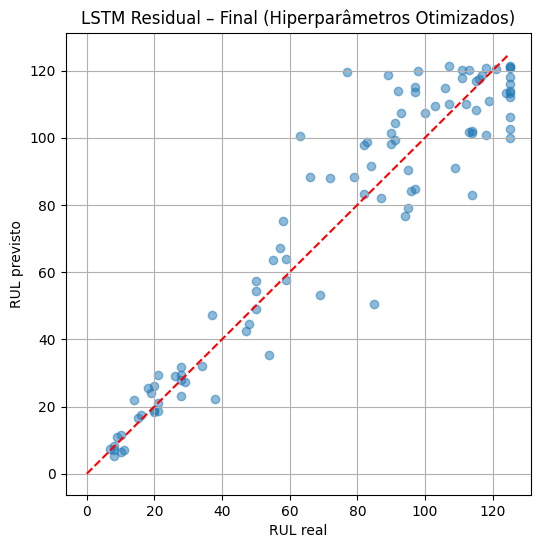

In [ ]:
# ============================================================
# LSTM RESIDUAL FINAL – HIPERPARÂMETROS OTIMIZADOS (FD001)
# Arquitetura oficial + melhores hiperparâmetros da random search
# ============================================================

import os, random
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# ============================================================
# FUNÇÃO OFICIAL DA PONTUAÇÃO S (PHM08)
# ============================================================
def s_score(y_true, y_pred):
    """
    Implementação vetorizada do S-Score da competição PHM08.
    Penaliza subestimativas mais fortemente do que superestimativas.
    """
    d = y_pred - y_true
    s = np.where(
        d < 0,
        np.exp(-d / 13) - 1,   # subestimou
        np.exp(d / 10) - 1     # superestimou
    )
    return np.sum(s)


# ============================================================
# CONFIGURAÇÕES INICIAIS
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

# ============================================================
# LEITURA DOS DADOS FD001
# ============================================================
base = "CMAPSSData/"
train = pd.read_csv(base + "train_FD001.txt", sep=r"\s+", header=None)
test  = pd.read_csv(base + "test_FD001.txt",  sep=r"\s+", header=None)
rul   = pd.read_csv(base + "RUL_FD001.txt",   sep=r"\s+", header=None)

col_names = ["unit_nr", "time_cycles", "setting_1", "setting_2", "setting_3"] \
    + [f"s{i}" for i in range(1, 22)]
train.columns = col_names
test.columns  = col_names

print("Train:", train.shape, "Test:", test.shape)

# ============================================================
# RUL COM LIMITE (125)
# ============================================================
rul_cap = 125
rul_dict = {i+1: rul.iloc[i, 0] for i in range(len(rul))}

def add_rul(df, is_test=False):
    df = df.copy()
    m = df.groupby("unit_nr")["time_cycles"].max().reset_index()
    m.columns = ["unit_nr", "max_cycle"]
    df = df.merge(m, on="unit_nr", how="left")
    df["RUL"] = df["max_cycle"] - df["time_cycles"]
    if is_test:
        df["RUL"] += df["unit_nr"].map(rul_dict)
    df["RUL"] = df["RUL"].clip(upper=rul_cap)
    df.drop("max_cycle", axis=1, inplace=True)
    return df

train = add_rul(train)
test  = add_rul(test, is_test=True)

# ============================================================
# REMOVE SENSORES CONSTANTES
# ============================================================
const_cols = [c for c in train.columns if train[c].nunique() == 1]
train.drop(columns=const_cols, inplace=True)
test.drop(columns=const_cols, inplace=True)
print("Sensores removidos:", const_cols)

# ============================================================
# FEATURE ENGINEERING (MEAN5, STD5, SLOPE)
# ============================================================
def add_features(df):
    df = df.copy()
    sensor_cols = [c for c in df.columns if c.startswith("s")]
    for s in sensor_cols:
        df[f"{s}_mean5"] = df.groupby("unit_nr")[s].rolling(5, min_periods=1).mean().reset_index(0,drop=True)
        df[f"{s}_std5"]  = df.groupby("unit_nr")[s].rolling(5, min_periods=1).std().reset_index(0,drop=True).fillna(0)
        df[f"{s}_slope"] = df.groupby("unit_nr")[s].diff().fillna(0)
    return df

train = add_features(train)
test  = add_features(test)

# ============================================================
# NORMALIZAÇÃO GLOBAL POR FEATURE
# ============================================================
feature_cols = [c for c in train.columns if c not in ["unit_nr", "time_cycles", "RUL"]]

scaler = MinMaxScaler()
train[feature_cols] = scaler.fit_transform(train[feature_cols])
test[feature_cols]  = scaler.transform(test[feature_cols])

# ============================================================
# CRIAÇÃO DAS JANELAS 30
# ============================================================
def make_sequences(df, window=30):
    X, y, units = [], [], []
    for u in df["unit_nr"].unique():
        unit_df = df[df["unit_nr"] == u]
        feat = unit_df[feature_cols].values
        rul  = unit_df["RUL"].values
        for i in range(len(feat) - window):
            X.append(feat[i:i+window])
            y.append(rul[i+window])
            units.append(u)
    return np.array(X), np.array(y), np.array(units)

WINDOW = 30
X_all, y_all, units_all = make_sequences(train)

# ============================================================
# DIVISÃO TEMPORAL 80/20 POR MOTOR
# ============================================================
unique_units = np.unique(units_all)
n_train = int(0.8 * len(unique_units))
train_units = unique_units[:n_train]
val_units   = unique_units[n_train:]

mask_train = np.isin(units_all, train_units)
mask_val   = np.isin(units_all, val_units)

X_train, y_train = X_all[mask_train], y_all[mask_train]
X_val,   y_val   = X_all[mask_val],   y_all[mask_val]

print("X_train:", X_train.shape, "X_val:", X_val.shape)

# ============================================================
# MODELO LSTM RESIDUAL – HIPERPARÂMETROS OTIMIZADOS
# ============================================================
def build_residual_lstm(n_timesteps, n_features):

    inp = layers.Input(shape=(n_timesteps, n_features))

    # LSTM 1
    x1 = layers.LSTM(96, return_sequences=True)(inp)
    x1 = layers.Dropout(0.1)(x1)

    # LSTM 2
    x2 = layers.LSTM(96, return_sequences=True)(x1)
    x2 = layers.Dropout(0.1)(x2)

    # Residual
    res1 = layers.add([x1, x2])

    # LSTM 3
    x3 = layers.LSTM(48)(res1)
    x3 = layers.Dropout(0.1)(x3)

    out = layers.Dense(1, activation="relu")(x3)

    model = keras.Model(inputs=inp, outputs=out)

    model.compile(
        loss="mse",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=[
            keras.metrics.MeanAbsoluteError(name="mae"),
            keras.metrics.RootMeanSquaredError(name="rmse")
        ]
    )
    return model

model = build_residual_lstm(WINDOW, len(feature_cols))
model.summary()

# ============================================================
# TREINO FINAL
# ============================================================
early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
reduce = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=120,
    batch_size=32,
    callbacks=[early, reduce],
    verbose=1
)

# === SALVAR MODELO ===
# model.save("model.h5")

# === SALVAR SCALER IGUAL AO DO TREINO ===
# import joblib
# joblib.dump(scaler, "scaler.pkl")


# ============================================================
# TESTE – ÚLTIMA JANELA
# ============================================================
def make_test_last(df, window=30):
    X, y = [], []
    for u in df["unit_nr"].unique():
        unit_df = df[df["unit_nr"] == u]
        feat = unit_df[feature_cols].values
        rul  = unit_df["RUL"].values
        X.append(feat[-window:])
        y.append(rul[-1])
    return np.array(X), np.array(y)

X_test, y_test = make_test_last(test)
pred = model.predict(X_test).flatten()

rmse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)
s = s_score(y_test, pred)

print("\n=========== RESULTADO FINAL – ÚLTIMA JANELA ===========")
print(f"MAE      = {mae:.2f}")
print(f"RMSE     = {rmse:.2f}")
print(f"S-Score  = {s:.2f}")

# ============================================================
# DISPERSÃO
# ============================================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, pred, alpha=0.5)
plt.plot([0,125],[0,125],'r--')
plt.xlabel("RUL real")
plt.ylabel("RUL previsto")
plt.title("LSTM Residual – Final (Hiperparâmetros Otimizados)")
plt.grid()
plt.show()